<a href="https://www.kaggle.com/code/vedantpancholi/titanic-dataset?scriptVersionId=215300396" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim


In [2]:
# Load Titanic dataset 
data = pd.read_csv("/kaggle/input/titanic-dataset/Titanic-Dataset.csv")
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# Preprocess data
def preprocess_data(data):
    # Fill missing values
    data['Age'].fillna(data['Age'].mean(), inplace=True)
    data['Embarked'].fillna(data['Embarked'].mode()[0], inplace=True)
    
    # Drop irrelevant columns
    data = data.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
    
    # Encode categorical features
    label_encoders = {}
    for col in ['Sex', 'Embarked']:
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col])
        label_encoders[col] = le

    return data

data = preprocess_data(data)
data.head(10)


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.000000,1,0,7.2500,2
1,1,1,0,38.000000,1,0,71.2833,0
2,1,3,0,26.000000,0,0,7.9250,2
3,1,1,0,35.000000,1,0,53.1000,2
4,0,3,1,35.000000,0,0,8.0500,2
5,0,3,1,29.699118,0,0,8.4583,1
6,0,1,1,54.000000,0,0,51.8625,2
7,0,3,1,2.000000,3,1,21.0750,2
8,1,3,0,27.000000,0,2,11.1333,2
9,1,2,0,14.000000,1,0,30.0708,0


In [4]:
data.shape

(891, 8)

In [5]:
# Split data into features and labels
X = data.drop('Survived', axis=1)
y = data['Survived']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [6]:
# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert data to PyTorch tensors for ANN
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)


In [7]:
# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert data to PyTorch tensors for ANN
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)



In [8]:
# ANN Model
class TitanicANN(nn.Module):
    def __init__(self, input_size):
        super(TitanicANN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        # x = torch.sigmoid(self.fc3(x))
        x = self.fc3(x)
        return x



In [9]:
# Train ANN
input_size = X_train.shape[1]
model = TitanicANN(input_size)
# print(model)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")



Epoch [10/50], Loss: 0.6092
Epoch [20/50], Loss: 0.5477
Epoch [30/50], Loss: 0.4898
Epoch [40/50], Loss: 0.4466
Epoch [50/50], Loss: 0.4244


Here, model(X_test_tensor) calls the forward method to get the raw output scores (logits) for each test sample. Then, torch.argmax(model(X_test_tensor), axis=1) selects the class with the highest probability (the predicted class).

In [10]:
# Evaluate ANN
model.eval()
with torch.no_grad():
    y_pred_ann = torch.argmax(model(X_test_tensor), axis=1).numpy()
accuracy_ann = accuracy_score(y_test, y_pred_ann)
print(f"ANN Accuracy: {accuracy_ann:.2f}")



ANN Accuracy: 0.81


In [11]:
# SVM Model
svm_model = SVC()
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"SVM Accuracy: {accuracy_svm:.2f}")



SVM Accuracy: 0.82


In [12]:
# Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf:.2f}")



Random Forest Accuracy: 0.82


In [13]:
# Decision Tree Model
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f"Decision Tree Accuracy: {accuracy_dt:.2f}")



Decision Tree Accuracy: 0.79


In [14]:
# Logistic Regression Model
lr_model = LogisticRegression(max_iter=200)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f"Logistic Regression Accuracy: {accuracy_lr:.2f}")



Logistic Regression Accuracy: 0.81


In [15]:
# K-Nearest Neighbors Model
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"K-Nearest Neighbors Accuracy: {accuracy_knn:.2f}")



K-Nearest Neighbors Accuracy: 0.80


In [16]:
# XGBoost Model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"XGBoost Accuracy: {accuracy_xgb:.2f}")



XGBoost Accuracy: 0.80



Comparison of Classifier Accuracies:
                 Model  Accuracy
0                  ANN  0.810056
1                  SVM  0.815642
2        Random Forest  0.815642
3        Decision Tree  0.787709
4  Logistic Regression  0.810056
5                  KNN  0.798883
6              XGBoost  0.798883


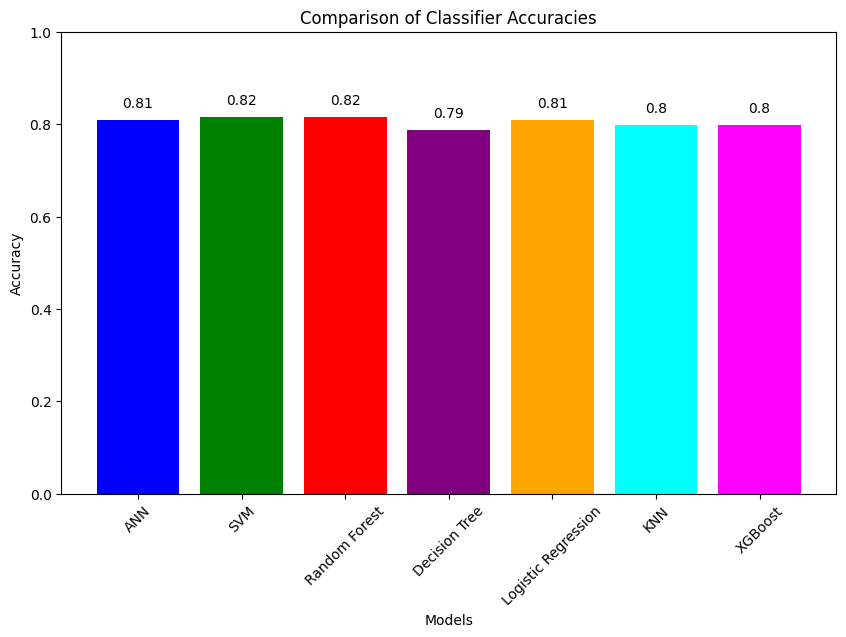

In [17]:
# Compare all classifiers
results = {
    'Model': ['ANN', 'SVM', 'Random Forest', 'Decision Tree', 'Logistic Regression', 'KNN', 'XGBoost'],
    'Accuracy': [accuracy_ann, accuracy_svm, accuracy_rf, accuracy_dt, accuracy_lr, accuracy_knn, accuracy_xgb]
}

results_df = pd.DataFrame(results)
print("\nComparison of Classifier Accuracies:")
print(results_df)


# Plot comparison of classifier accuracies
plt.figure(figsize=(10, 6))
bars = plt.bar(results_df['Model'], results_df['Accuracy'], color=['blue', 'green', 'red', 'purple', 'orange', 'cyan', 'magenta'])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Comparison of Classifier Accuracies')
plt.xticks(rotation=45)
plt.ylim(0, 1)

# Annotate bars with accuracy values
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.02, round(yval, 2), ha='center', va='bottom')

plt.show()

